In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

from fno_utils import FNO2d, FNODatasetSingle

ModuleNotFoundError: No module named 'fno_utils'

In [3]:
device = "cuda"

cfg_fn = os.path.join("experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [5]:
scores = []
downsampling = [1,2,4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

.H5 file extension is assumed hereafter


In [6]:
sample = yyhat[0,...,0,0].cpu().detach().numpy()

In [7]:
import pywt
coeffs = pywt.dwt2(sample, 'db2')
cA, (cH, cV, cD) = coeffs

In [8]:
rec_sample = pywt.idwt2(cA, cD, 'db2')

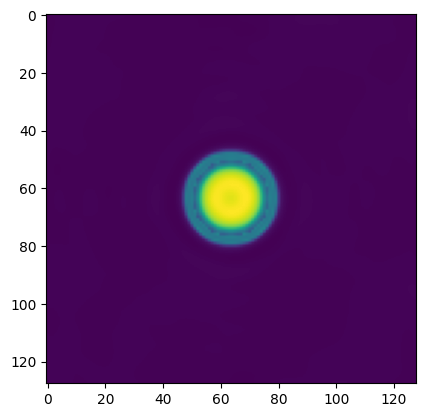

In [13]:
plt.imshow(rec_sample)

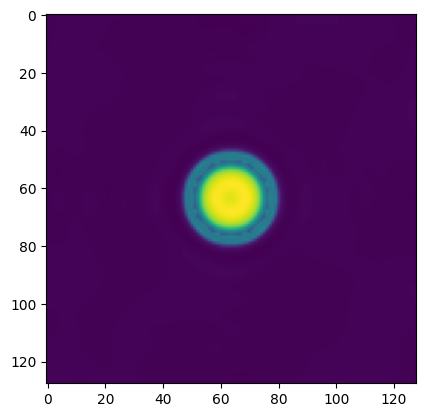

In [14]:
plt.imshow(sample)

In [25]:
x, y = sample_signal(test_func, scale)

In [45]:
coeffs = pywt.dwt(y, 'db6')
cA, cD = coeffs # cA coefficients (approximation) are for scaling (phi); cD (details) for wavelet (psi)
rec_sample = pywt.idwt(cA, cD, 'db6')

In [50]:
[phi, psi, x] = pywt.Wavelet('db6').wavefun(level=8) # phi - scaling; psi - wavelet

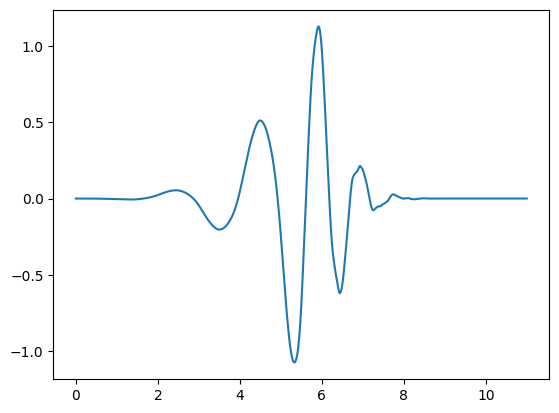

In [30]:
plt.plot(x, psi)

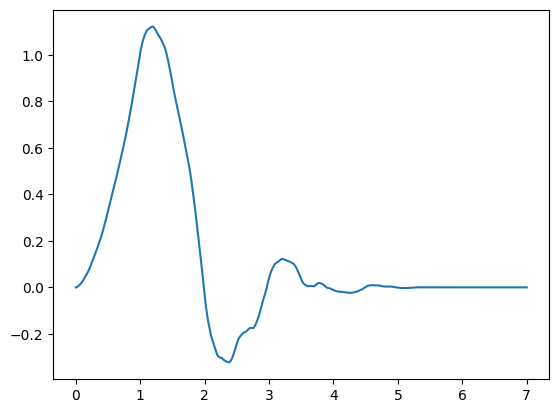

In [87]:
plt.plot(x, phi)
plt.show()

In [3]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

In [4]:
def test_func(x):
    k1 = 5
    k2 = 20
    k = k1 + (k2 - k1) * (4 * (x-0.5)**3 + 0.5)
    return np.sin(k * x)


In [5]:
def sample_signal(test_f, scale):
    dx = pow(2, -scale)
    x = np.arange(0, 1, dx)
    y = np.array([test_f(x[i]) for i in range(x.shape[0])])
    y = test_f(x)
    return x, y

In [6]:
# Generate discrete signal
scale = 7
x, y = sample_signal(test_func, scale)
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
coeffs = pywt.wavedec(y, wavelet)
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
phi, psi, x_wav = wavelet.wavefun(level=scale+2)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s = 1. / sqrt(pow(2, scale))
#dx = 4.e-3
x_rec = x #np.arange(0, 1, dx)
y_rec = []
# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

for i in range(x_rec.shape[0]):
    xi = x_rec[i] - A #pow(2, -scale)
    val = 0.

    # Approx
    c_a = coeffs[0]
    inv_s = pow(2, scale - nb_levels) 
    inv_sqrt_s = sqrt(inv_s) 
    for k in range(c_a.shape[0]):
        val += k_s * inv_sqrt_s * c_a[k] * phi[find_nearest(x_wav, inv_s * xi - k + B)]

    # Details
    for j in range(nb_levels):
        c_d = coeffs[j + 1]
        inv_s = pow(2, scale + j - nb_levels)
        inv_sqrt_s = sqrt(inv_s)
        for k in range(c_d.shape[0]):
            val += k_s * inv_sqrt_s * c_d[k] * psi[find_nearest(x_wav, inv_s * xi - k + B)]
    y_rec.append(val)
y_rec = np.array(y_rec)

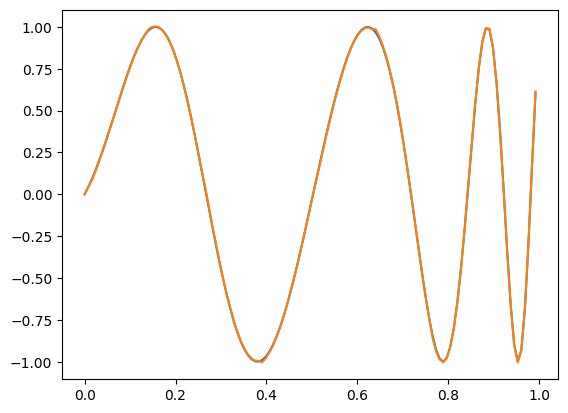

In [7]:
plt.plot(x, y)
plt.plot(x, y_rec)